We explored previously how to identify which features play the most important role in the Interaction Network's decision making process. Now we want to see what is happening inside the inner layers of the network. As the IN processes the input, it is passed through three different MLPs that approximate arbitrary non-linear functions called $f_R^{pp}, f_R^{vp},$ and $f_O$. We will explore the activity of each neuron and compare it with the activity of neurons in the same layer. For the $j$-th neuron in layer $k$, we define the quantity *Relative Neural Activity (RNA)* as following-

\begin{equation}
\mathrm{RNA}(i,j;\mathcal{S}) = \frac{\sum_{i=1}^{N} a_{j,k} (s_i)}{\max_j\sum_{i=1}^{N} a_{j,k}(s_i)}
\end{equation}

where $\mathcal{S} =\{s_1, s_2 ... s_N\}$ represents a set of samples over which the $\mathrm{RNA}$ score is evaluated. The quantity $a_{j,k} (s_i)$ is the activation of $j$-th neuron in the $k$-th layer when the input to the network is $s_i$. When summed over all the samples in the evaluation set $\mathcal{S}$, this represents the cumulative neural response of a node, which is normalized with respect to the largest cumulative neural response in the same layer to obtain the $\mathrm{RNA}$ score. Hence, in each layer, there will be at least one node with an $\mathrm{RNA}$ score of 1. Since the neurons are activated with RELU activation in the IN model, the $\mathrm{RNA}$ score will be strictly non-negative, and $\leq 1$.


In a qualitative way, we are trying to see which neurons most actively engage to obtain the predictions from the IN model. Since the MLPs in the IN model consist of only Dense layers, each layer takes all the activations from the previous layer as inputs. As all nodes within a given layer are subject to the same set of inputs, we can reliably estimate how strongly they perceive and transfer that information to the next layer by looking at their activation values. 

In [1]:
import torch
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import glob
import json
import torch.nn as nn
import os
import sys
sys.path.append("..")
sys.path.append("../src")
from models import models
from data import h5data

params = ['track_ptrel',
          'track_erel',
          'track_phirel',
          'track_etarel',
          'track_deltaR',
          'track_drminsv',
          'track_drsubjet1',
          'track_drsubjet2',
          'track_dz',
          'track_dzsig',
          'track_dxy',
          'track_dxysig',
          'track_normchi2',
          'track_quality',
          'track_dptdpt',
          'track_detadeta',
          'track_dphidphi',
          'track_dxydxy',
          'track_dzdz',
          'track_dxydz',
          'track_dphidxy',
          'track_dlambdadz',
          'trackBTag_EtaRel',
          'trackBTag_PtRatio',
          'trackBTag_PParRatio',
          'trackBTag_Sip2dVal',
          'trackBTag_Sip2dSig',
          'trackBTag_Sip3dVal',
          'trackBTag_Sip3dSig',
          'trackBTag_JetDistVal'
         ]

params_sv = ['sv_ptrel',
          'sv_erel',
          'sv_phirel',
          'sv_etarel',
          'sv_deltaR',
          'sv_pt',
          'sv_mass',
          'sv_ntracks',
          'sv_normchi2',
          'sv_dxy',
          'sv_dxysig',
          'sv_d3d',
          'sv_d3dsig',
          'sv_costhetasvpv'
         ]

def_state_dict = torch.load('../models/trained_models/gnn_baseline_best.pth')


for key in def_state_dict.keys():
    print(key, def_state_dict[key].shape)

batch_size = 1024
files = glob.glob("../src/models/dataset/train/newdata_*.h5")
files_val = files[:1] # take first 5 for validation
data_val = h5data.H5Data(batch_size = batch_size,
                         cache = None,
                         preloading=0,
                         features_name='training_subgroup',
                         labels_name='target_subgroup',
                         spectators_name='spectator_subgroup')
data_val.set_file_names(files_val)


Ntracks = 60
Nclasses = 2
hidden = 60
Nverts = 5

softmax = torch.nn.Softmax(dim=1)
gnn_0 = models.GraphNet(Ntracks, Nclasses, len(params), hidden, Nverts, len(params_sv),
                        vv_branch=0,
                        De=20,
                        Do=24)
gnn_0.load_state_dict(def_state_dict)

fr1.weight torch.Size([60, 60])
fr1.bias torch.Size([60])
fr2.weight torch.Size([60, 60])
fr2.bias torch.Size([60])
fr3.weight torch.Size([20, 60])
fr3.bias torch.Size([20])
fr1_pv.weight torch.Size([60, 44])
fr1_pv.bias torch.Size([60])
fr2_pv.weight torch.Size([60, 60])
fr2_pv.bias torch.Size([60])
fr3_pv.weight torch.Size([20, 60])
fr3_pv.bias torch.Size([20])
fo1.weight torch.Size([60, 70])
fo1.bias torch.Size([60])
fo2.weight torch.Size([60, 60])
fo2.bias torch.Size([60])
fo3.weight torch.Size([24, 60])
fo3.bias torch.Size([24])
fc_fixed.weight torch.Size([2, 24])
fc_fixed.bias torch.Size([2])


<All keys matched successfully>

To obtain the $\mathrm{RNA}$ score for each neuron, we need to store the intermediate activation values. Below, we define the `NeuronFiringEvaluator` method, developed by modifying the `forward` method of the `GraphNet` class. For every evaluation between layers, this method updates the cumulative neural response of the corresponding neurons.

In [2]:
def NeuronFiringEvaluator(model, x, y, weighted_firing=False):
    FiringEvaluator = []
    layer_tags = []
    ###PF Candidate - PF Candidate###
    Orr = model.tmul(x, model.Rr)
    Ors = model.tmul(x, model.Rs)
    B = torch.cat([Orr, Ors], 1)
    ### First MLP ###
    B = torch.transpose(B, 1, 2).contiguous()
    B = nn.functional.relu(model.fr1(B.view(-1, 2 * model.P + model.Dr)))
    
    if not weighted_firing:
        FiringEvaluator.append(torch.sum(B > 0, 0).cpu().numpy())
    else:
        FiringEvaluator.append(torch.sum(B, 0).cpu().numpy())
    layer_tags.append(r"$f_R^{pp}:1$")
    
    B = nn.functional.relu(model.fr2(B))
    if not weighted_firing:
        FiringEvaluator.append(torch.sum(B > 0, 0).cpu().numpy())
    else:
        FiringEvaluator.append(torch.sum(B, 0).cpu().numpy())
    
    layer_tags.append(r"$f_R^{pp}:2$")
    
    E = nn.functional.relu(model.fr3(B))
    if not weighted_firing:
        FiringEvaluator.append(torch.sum(E > 0, 0).cpu().numpy())
    else:
        FiringEvaluator.append(torch.sum(E, 0).cpu().numpy())

    layer_tags.append(r"$f_R^{pp}:3$")
    E = E.view(-1, model.Nr, model.De)
    
    del B
    E = torch.transpose(E, 1, 2).contiguous()
    Ebar_pp = model.tmul(E, torch.transpose(model.Rr, 0, 1).contiguous())
    del E

    ####Secondary Vertex - PF Candidate### 
    Ork = model.tmul(x, model.Rk)
    Orv = model.tmul(y, model.Rv)
    B = torch.cat([Ork, Orv], 1)
    ### First MLP ###
    B = torch.transpose(B, 1, 2).contiguous()
    B = nn.functional.relu(model.fr1_pv(B.view(-1, model.S + model.P + model.Dr)))
    if not weighted_firing:
        FiringEvaluator.append(torch.sum(B > 0, 0).cpu().numpy())
    else:
        FiringEvaluator.append(torch.sum(B, 0).cpu().numpy())
    
    layer_tags.append(r"$f_R^{vp}:1$")
    
    B = nn.functional.relu(model.fr2_pv(B))
    if not weighted_firing:
        FiringEvaluator.append(torch.sum(B > 0, 0).cpu().numpy())
    else:
        FiringEvaluator.append(torch.sum(B, 0).cpu().numpy())

    layer_tags.append(r"$f_R^{vp}:2$")
    
    E = nn.functional.relu(model.fr3_pv(B))
    if not weighted_firing:
        FiringEvaluator.append(torch.sum(E > 0, 0).cpu().numpy())
    else:
        FiringEvaluator.append(torch.sum(E, 0).cpu().numpy())

    layer_tags.append(r"$f_R^{vp}:3$")
    E = E.view(-1, model.Nt, model.De)
    
    del B
    E = torch.transpose(E, 1, 2).contiguous()
    Ebar_pv = model.tmul(E, torch.transpose(model.Rk, 0, 1).contiguous())
    Ebar_vp = model.tmul(E, torch.transpose(model.Rv, 0, 1).contiguous())
    del E

    ###Secondary vertex - secondary vertex###
    if model.vv_branch:
        Orl = model.tmul(y, model.Rl)
        Oru = model.tmul(y, model.Ru)
        B = torch.cat([Orl, Oru], 1)
        ### First MLP ###
        B = torch.transpose(B, 1, 2).contiguous()
        B = nn.functional.relu(model.fr1_vv(B.view(-1, 2 * model.S + model.Dr)))
        B = nn.functional.relu(model.fr2_vv(B))
        E = nn.functional.relu(model.fr3_vv(B).view(-1, model.Ns, model.De))
        del B
        E = torch.transpose(E, 1, 2).contiguous()
        Ebar_vv = model.tmul(E, torch.transpose(model.Rl, 0, 1).contiguous())
        del E

    ####Final output matrix for particles###
    C = torch.cat([x, Ebar_pp, Ebar_pv], 1)
    del Ebar_pp
    del Ebar_pv
    C = torch.transpose(C, 1, 2).contiguous()
    ### Second MLP ###
    C = nn.functional.relu(model.fo1(C.view(-1, model.P + model.Dx + (2 * model.De))))
    if not weighted_firing:
        FiringEvaluator.append(torch.sum(C > 0, 0).cpu().numpy())
    else:
        FiringEvaluator.append(torch.sum(C, 0).cpu().numpy())
    layer_tags.append(r"$f_O:1$")
    
    C = nn.functional.relu(model.fo2(C))
    if not weighted_firing:
        FiringEvaluator.append(torch.sum(C > 0, 0).cpu().numpy())
    else:
        FiringEvaluator.append(torch.sum(C, 0).cpu().numpy())
    layer_tags.append(r"$f_O:2$")
    
    O = nn.functional.relu(model.fo3(C))
    if not weighted_firing:
        FiringEvaluator.append(torch.sum(O > 0, 0).cpu().numpy())
    else:
        FiringEvaluator.append(torch.sum(O, 0).cpu().numpy())
    layer_tags.append(r"$f_O:3$")
    O = O.view(-1, model.N, model.Do)
    
    del C

    if model.vv_branch:
        ####Final output matrix for particles### 
        C = torch.cat([y, Ebar_vv, Ebar_vp], 1)
        del Ebar_vv
        del Ebar_vp
        C = torch.transpose(C, 1, 2).contiguous()
        ### Second MLP ###
        C = nn.functional.relu(model.fo1_v(C.view(-1, model.S + model.Dx + (2 * model.De))))
        C = nn.functional.relu(model.fo2_v(C))
        O_v = nn.functional.relu(model.fo3_v(C).view(-1, model.Nv, model.Do))
        del C

    #Taking the sum of over each particle/vertex
    N = torch.sum(O, dim=1)
    del O
    if model.vv_branch:
        N_v = torch.sum(O_v,dim=1)
        del O_v

    ### Classification MLP ###
    if model.vv_branch:
        N =model.fc_fixed(torch.cat([N, N_v],1))
    else:
        N = model.fc_fixed(N)

    if model.softmax:
        N = nn.Softmax(dim=-1)(N)

    return N, FiringEvaluator, layer_tags 

As you may have noted, there is `weighted_firing` flag that is passed on to this method. Setting this flag to `False` will simply count the number of times a neuron has fired and not consider the actual value or weight of the activation. In other words, with `weighted_firing = False`, the $a_{i,j}$ in the definition of $\mathrm{RNA}$ score will be replaced by the $\tilde{a}_{i,j}$, defined as-

\begin{equation}
\tilde{a}_{i,j} = \mathbf{1}\cdot\left(a_{i,j} > 0 \right)
\end{equation}

The *unweighted* $\mathrm{RNA}$ score reveals information about which nodes are actively participating in decision making process and which nodes are not. However, it alone isn't a reliable measure of a node's importance in the decision making process, since two nodes firing at the same rate can have very different activation values. We will look at this score for the baseline model as an exercise, but mostly  we will be suing the *weighted* $\mathrm{RNA}$ score.

Now let's define a method that will iterate over the evaluation dataset and return the necessary results. We want to separately inspect the $\mathrm{RNA}$ scores for QCD and $H\rightarrow b\bar{b}$ jets, so we are going to leave an option of specifying the `target_label` which will take the values of 0 and 1 respectively for the two jet categories. 

In [3]:
def eval(model,
         drop_pfeatures = torch.tensor([], dtype=torch.long),
         drop_svfeatures = torch.tensor([], dtype=torch.long), target_label = 1,
         weighted_firing = False):
    lst = []
    correct = []
    FiringMatrix = []
    ii = 0
    with torch.no_grad():
        for sub_X,sub_Y,sub_Z in data_val.generate_data():                                                                   
            training = sub_X[2]
            training_sv = sub_X[3]
            target = sub_Y[0]
            spec = sub_Z[0]
            keep_instances = target[:, 1] == target_label
            target = target[keep_instances, :]
            trainingv = (torch.FloatTensor(training)).cuda()
            trainingv = trainingv[keep_instances, :, :]
            if len(drop_pfeatures) > 0:
                keep_features = [i for i in np.arange(0,len(params),1, dtype=int) if i not in drop_pfeatures]
                trainingv = trainingv[:,keep_features,:]
            trainingv_sv = (torch.FloatTensor(training_sv)).cuda()
            trainingv_sv = trainingv_sv[keep_instances, :, :]
            if len(drop_svfeatures) > 0:
                keep_features = [i for i in np.arange(0,len(params_sv),1, dtype=int) if i not in drop_svfeatures]
                trainingv_sv = trainingv_sv[:,keep_features,:]
            targetv = (torch.from_numpy(np.argmax(target, axis = 1)).long()).cuda()
    
            out, FiringEvaluator, layer_tags = NeuronFiringEvaluator(model, trainingv.cuda(), 
                                                                     trainingv_sv.cuda(), weighted_firing)
            if ii == 0:
                for jj in range(len(FiringEvaluator)):
                    FiringMatrix.append(FiringEvaluator[jj])
            else:
                for jj in range(len(FiringEvaluator)):
                    FiringMatrix[jj] += FiringEvaluator[jj]
            lst.append(softmax(out).cpu().data.numpy())
            correct.append(target)
            ii += 1
    
    predicted = np.concatenate(lst)
    val_targetv = np.concatenate(correct)
    
    return predicted, val_targetv, FiringMatrix, layer_tags

Now let's obtain the $\mathrm{RNA}$ scores for the two jet categories.

In [4]:
predicted_0, val_targetv_0, FiringMatrix_0, layer_tags = eval(gnn_0,target_label = 0)

In [5]:
predicted_1, val_targetv_1, FiringMatrix_1, layer_tags = eval(gnn_0,target_label = 1)

We are now going to develop a way of visulasing the $\mathrm{RNA}$ scores as **Neural Activity Pattern (NAP)** diagrams. We will display it as a 2D heat map where along X axis will be placed the different activation layers we intend to inspect and the Y axis will have the nodes in each layer. To demonstrate the NAP diagrams for the two jet categories side by side, we are going to multiply the $\mathrm{RNA}$ scores for the QCD jet category by -1.

We will also look at the difference in $\mathrm{RNA}$ scores for the two categories in a separate but similarly organized heat map. These diagrams will tell us at which stage of information propagation the network starts to learn about the two categories and how this information is distributed in the hidden or latent space dimensions.

In [6]:
def ActivationMapPlotter(FiringMatrix_0, FiringMatrix_1, layer_tags, tag='baseline'):
    N_cols = len(FiringMatrix_0)
    N_rows = max([len(i) for i in FiringMatrix_0])
    
    for ii in range(len(FiringMatrix_0)):
        max_0 = FiringMatrix_0[ii].max()
        max_1 = FiringMatrix_1[ii].max()
        FiringMatrix_0[ii] = FiringMatrix_0[ii]/max_0
        FiringMatrix_1[ii] = FiringMatrix_1[ii]/max_1
    for ii in range(N_cols):
        if len(FiringMatrix_0[ii]) < N_rows:
            FiringMatrix_0[ii] = np.append(FiringMatrix_0[ii], 
                                           np.ones(N_rows - len(FiringMatrix_0[ii]))*np.nan)
            FiringMatrix_1[ii] = np.append(FiringMatrix_1[ii], 
                                           np.ones(N_rows - len(FiringMatrix_1[ii]))*np.nan)
    
    FiringMatrix_0 = np.array(FiringMatrix_0)
    FiringMatrix_1 = np.array(FiringMatrix_1)

    print("Sparsity measure (RNA < 0.2) for QCD jets: ", np.sum(FiringMatrix_0 < 0.2)/FiringMatrix_0.size)
    print("Sparsity measure (RNA < 0.2) for Hbb jets: ", np.sum(FiringMatrix_1 < 0.2)/FiringMatrix_1.size)
    ## The relative node firing rates for class 0 are multiplied by a factor of -1
    ## to represent the NAPs of two classes side by side for a visual comparison
    weights = np.append(-1*FiringMatrix_0.reshape(-1), FiringMatrix_1.reshape(-1)) 
    x = np.array([np.arange(N_cols)]*N_rows).T.reshape(-1) + 0.25
    x = np.append(x, np.array([np.arange(N_cols)]*N_rows).T.reshape(-1) + 0.75)
    y = np.array([np.arange(N_rows)]*N_cols).reshape(-1) + 0.5
    y = np.append(y,y)
    
    fig, axes = plt.subplots(1,1,figsize=(6,6))
    _,_,_,im = axes.hist2d(x,y,
                   bins=[np.arange(0,N_cols+0.25,0.5), np.arange(N_rows+1)],
                   weights = weights, cmap = 'bwr', cmin = -1, cmax = 1)
    axes.set_facecolor('black')

    fig.colorbar(im, ax=axes)
    axes.set_xlabel('Network Activation Layers')
    axes.set_ylabel('Node in hidden layer')
    axes.set_xticks(np.arange(N_cols) + 0.5) 
    axes.set_xticklabels(layer_tags, rotation='vertical')
    plt.tight_layout()
    plt.savefig("../reports/figures/plots_xAI/NAP_{}.pdf".format(tag))
    plt.show()
    
    
    fig, axes = plt.subplots(1,1,figsize=(6,6))
    weights = np.abs(FiringMatrix_1.reshape(-1) - FiringMatrix_0.reshape(-1))
    x = np.array([np.arange(N_cols)]*N_rows).T.reshape(-1) + 0.5
    y = np.array([np.arange(N_rows)]*N_cols).reshape(-1) + 0.5
    _,_,_,im = axes.hist2d(x,y,
                   bins=[np.arange(N_cols+1), np.arange(N_rows+1)],
                   weights = weights, cmap = 'Reds')

    fig.colorbar(im, ax=axes)
    axes.set_facecolor('black')
    axes.set_xlabel('Network Activation Layers')
    axes.set_ylabel('Node in hidden layer')
    axes.set_xticks(np.arange(N_cols) + 0.5)
    axes.set_xticklabels(layer_tags, rotation='vertical')

    plt.savefig("../reports/figures/plots_xAI/dNAP_{}.pdf".format(tag))
    plt.show()
    

Now, let's take a look at the *unweighted* NAP diagram for the baseline model.

Sparsity measure (RNA < 0.2) for QCD jets:  0.21851851851851853
Sparsity measure (RNA < 0.2) for Hbb jets:  0.22037037037037038


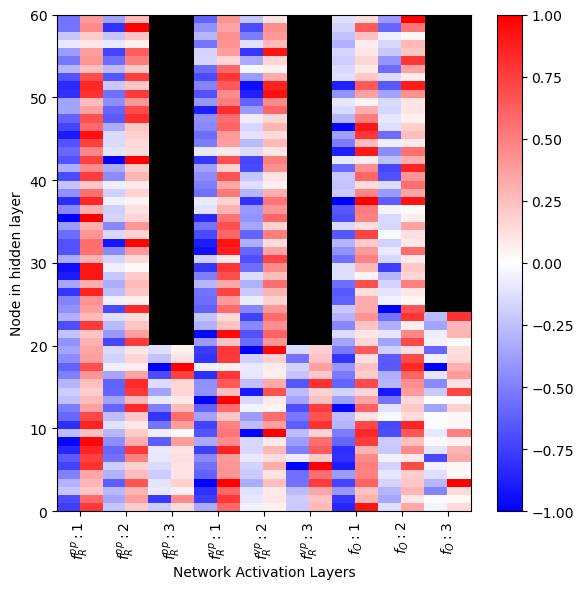

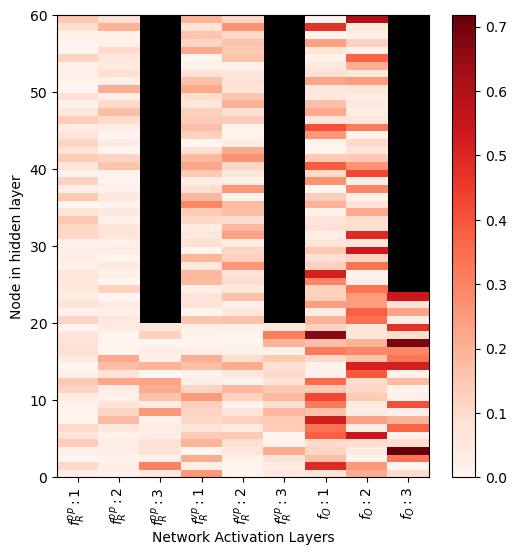

In [7]:
ActivationMapPlotter(FiringMatrix_0, FiringMatrix_1, layer_tags, tag='baseline_unweighted')

The first of these two diagrams show how the relative count of neuron firing varies for different nodes in a given layer. Most neurons show activity for both jet categories, but this diagram doesn't take into account the activation strength or weights for them. The second diagram shows us the difference in $\mathrm{RNA}$ scores for the two jet categories. These diagrams enable us to make a few important observations- the same nodes fire most frequently for $f_R^{pp}$ and $f_R^{vp}$ netowrks for both jet categories. This implies that the network accumulates information about the jet categories in the same nodes for these networks. On the other hand, notable difference in firing patterns can be observed in the node firing activity for the aggregator network $f_O$. This implies that the aggregator network disentangles the information about the jet's class and stores them into different dimensions of its latent space representation.

Now we can take a look at the *weighted* NAP diagrams.

Sparsity measure (RNA < 0.2) for QCD jets:  0.4425925925925926
Sparsity measure (RNA < 0.2) for Hbb jets:  0.43333333333333335


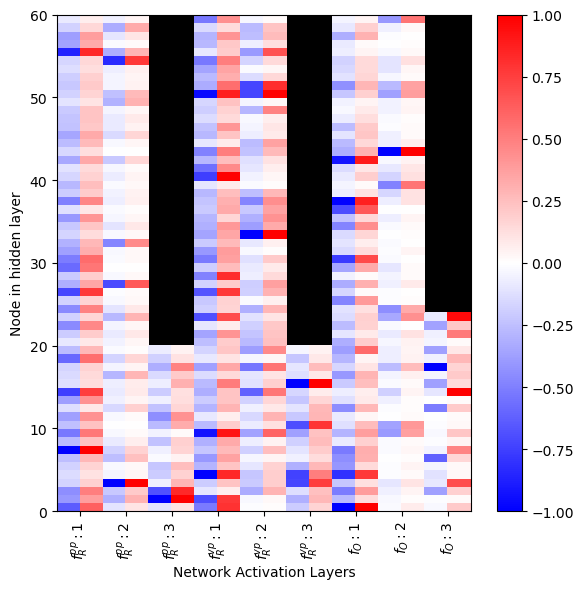

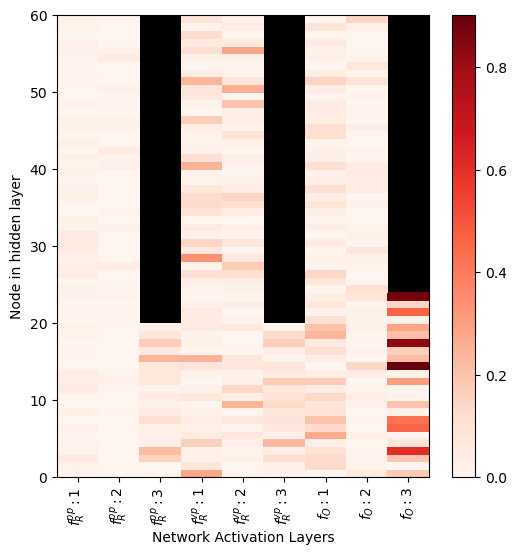

In [8]:
predicted_0, val_targetv_0, FiringMatrix_0, layer_tags = eval(gnn_0, target_label = 0, weighted_firing = True)
predicted_1, val_targetv_1, FiringMatrix_1, layer_tags = eval(gnn_0, target_label = 1, weighted_firing = True)
ActivationMapPlotter(FiringMatrix_0, FiringMatrix_1, layer_tags, tag='baseline_weighted')

The NAP diagram clearly shows that the network's activity level is quite sparse. In some layers, more than half of the nodes show $\mathrm{RNA}$ scores less than 0.2. It implies that while some nodes are playing very important roles in propagating the necessary information, other nodes don't participate as much. This indicates that the model can be made simpler, by reducing the number of nodes in the hidden layers as well the dimensions of the latent space representation. We also see that model effectively disentangles the representation of the jet classes primarily at the outputlayer of the aggregator network and the relative activity level of other nodes in propagating that information is very similar for both jet classes.

This motivates us to explore training simpler models where we can not only learn the jet classification task from a considerably smaller feature set but also with a relatively simpler model, with a signifcantly smaller number of trainable parameters.

The following code block generates the NAP diagrams for the other models we have trained, including models where features have been pruned and the hyperparameters are changed.

gnn_De16_model_metadata.json
Sparsity measure (RNA < 0.2) for QCD jets:  0.42407407407407405
Sparsity measure (RNA < 0.2) for Hbb jets:  0.44814814814814813


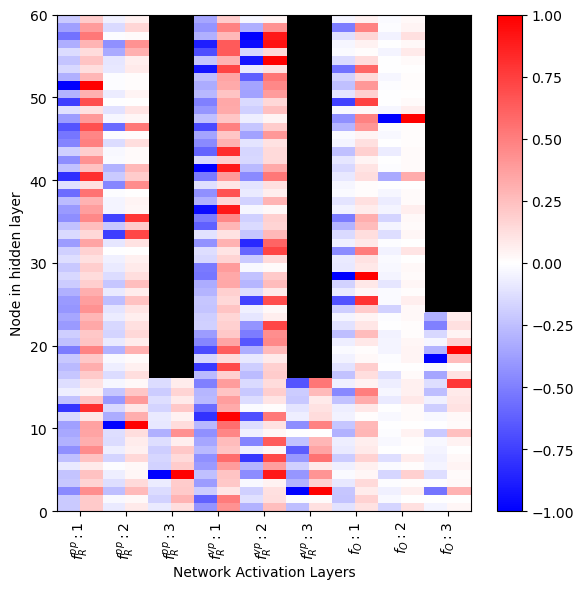

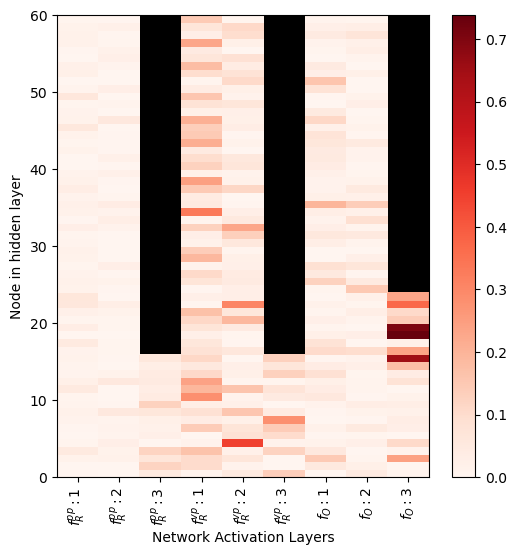

gnn_De8_model_metadata.json
Sparsity measure (RNA < 0.2) for QCD jets:  0.42777777777777776
Sparsity measure (RNA < 0.2) for Hbb jets:  0.3907407407407407


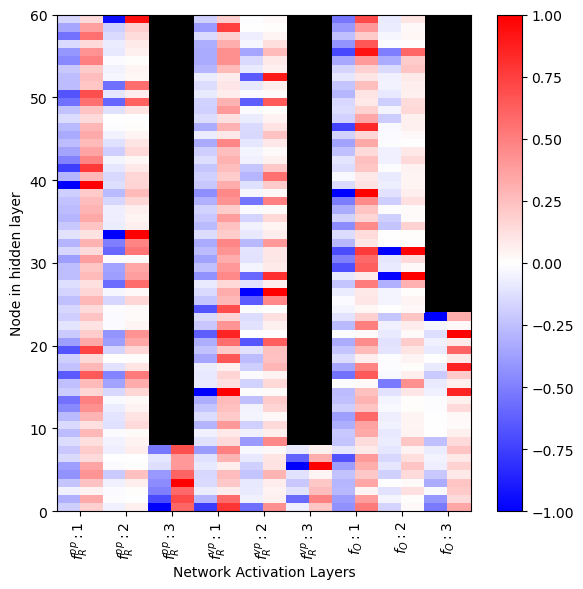

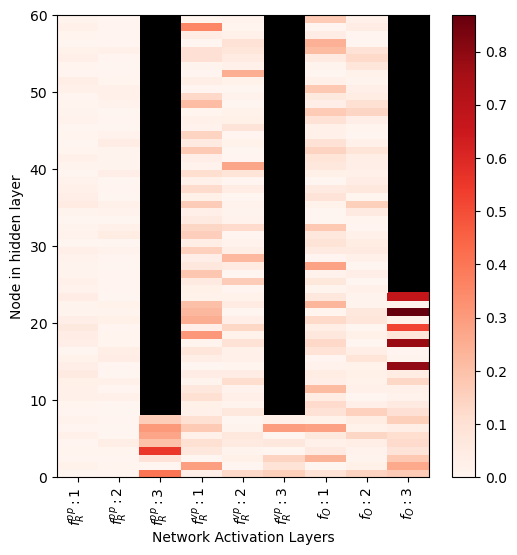

gnn_Do16_model_metadata.json
Sparsity measure (RNA < 0.2) for QCD jets:  0.4148148148148148
Sparsity measure (RNA < 0.2) for Hbb jets:  0.42592592592592593


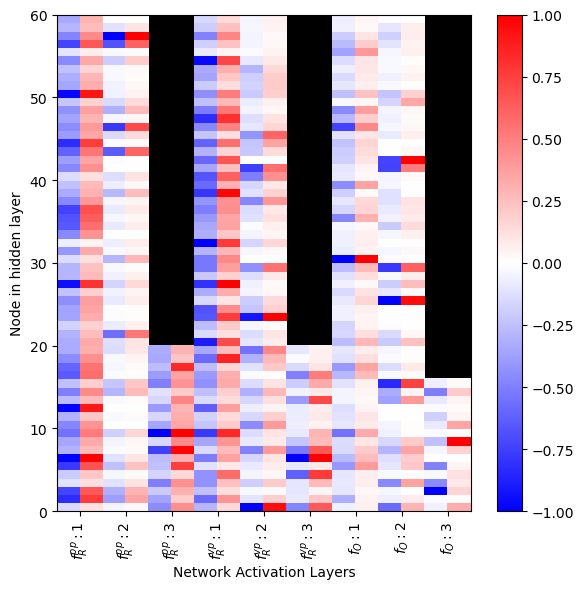

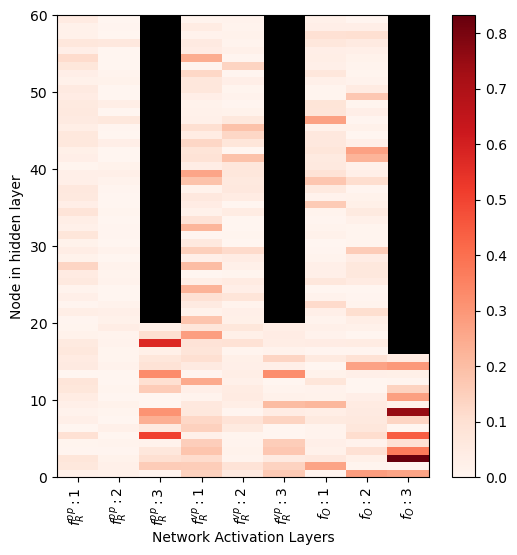

gnn_Do8_model_metadata.json
Sparsity measure (RNA < 0.2) for QCD jets:  0.4148148148148148
Sparsity measure (RNA < 0.2) for Hbb jets:  0.4351851851851852


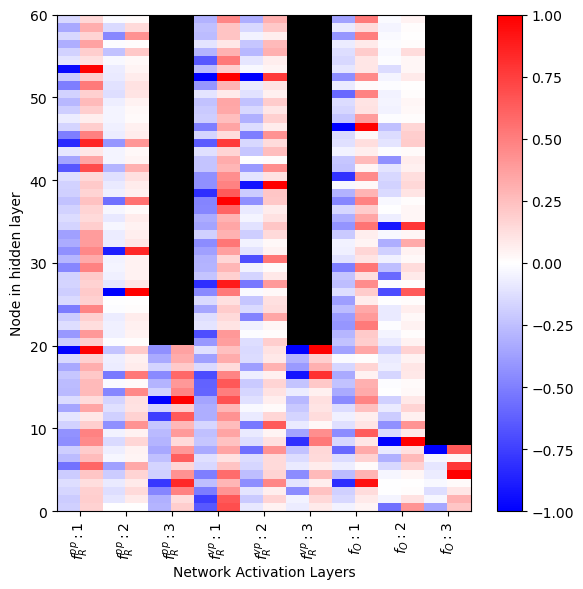

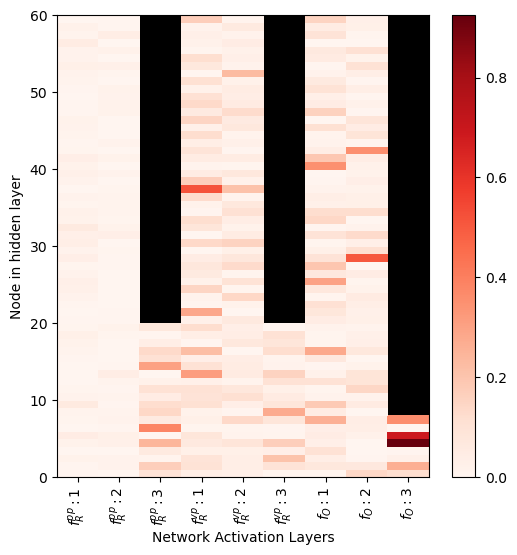

gnn_hidden32_model_metadata.json
Sparsity measure (RNA < 0.2) for QCD jets:  0.4236111111111111
Sparsity measure (RNA < 0.2) for Hbb jets:  0.4131944444444444


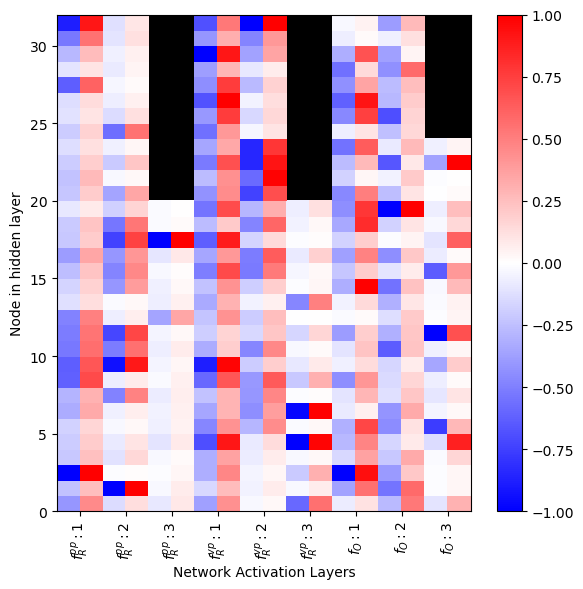

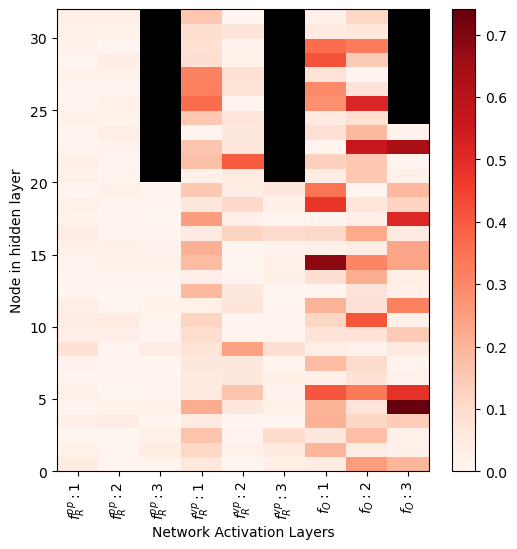

gnn_hidden40_model_metadata.json
Sparsity measure (RNA < 0.2) for QCD jets:  0.39166666666666666
Sparsity measure (RNA < 0.2) for Hbb jets:  0.4083333333333333


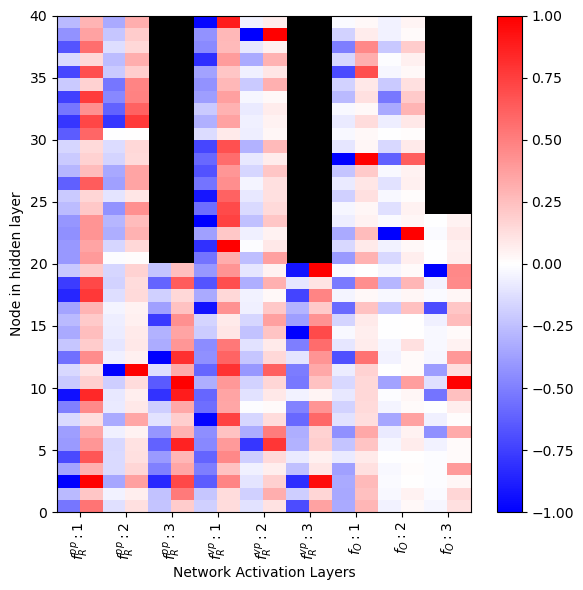

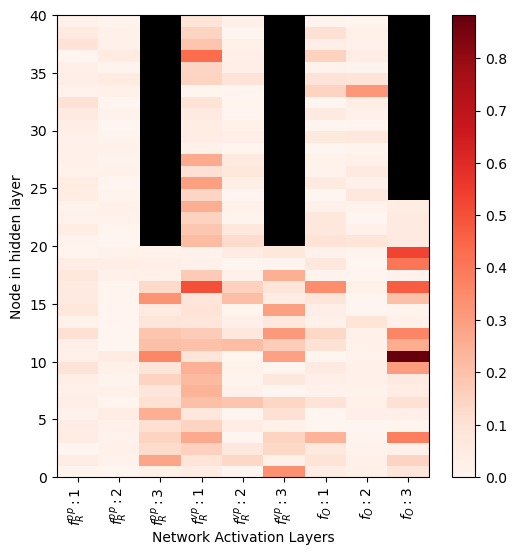

gnn_pfeaturesdropped14_hidden16_De8_Do8_model_metadata.json
Sparsity measure (RNA < 0.2) for QCD jets:  0.3333333333333333
Sparsity measure (RNA < 0.2) for Hbb jets:  0.3680555555555556


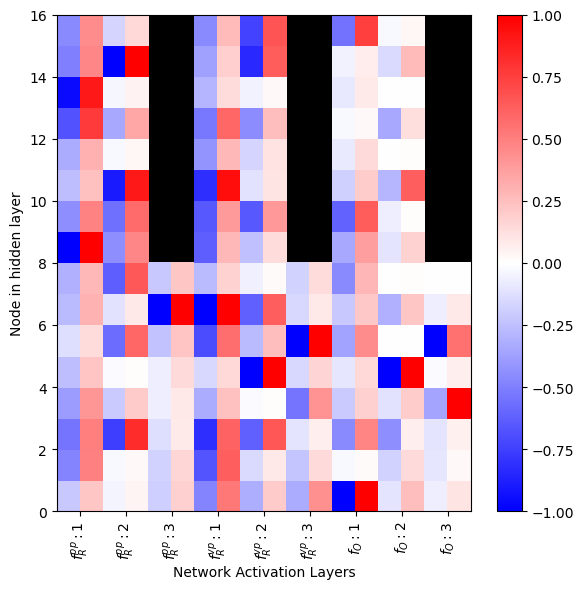

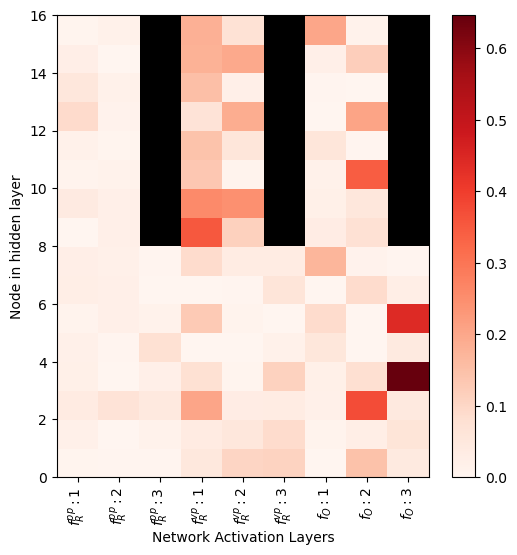

gnn_pfeaturesdropped14_hidden32_De16_Do16_model_metadata.json
Sparsity measure (RNA < 0.2) for QCD jets:  0.4756944444444444
Sparsity measure (RNA < 0.2) for Hbb jets:  0.4965277777777778


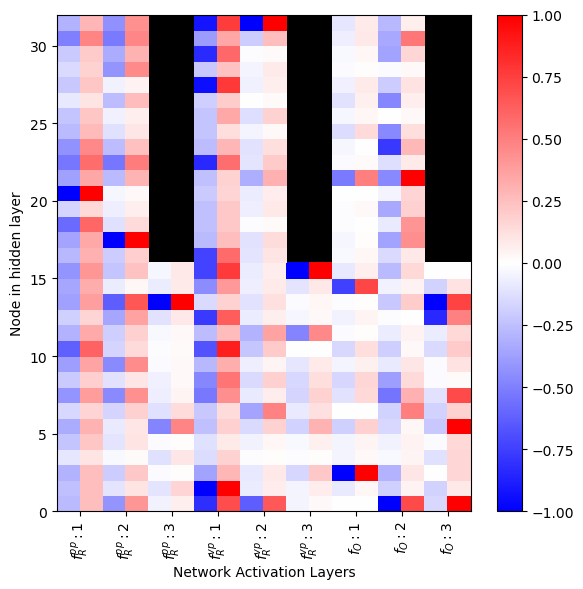

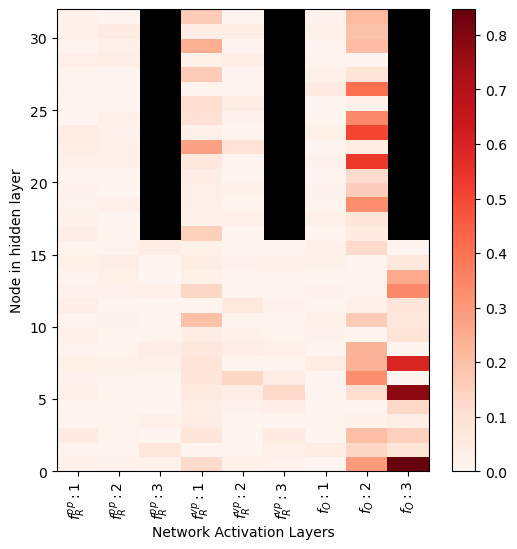

gnn_pfeaturesdropped14_hidden32_De8_Do8_model_metadata.json
Sparsity measure (RNA < 0.2) for QCD jets:  0.2673611111111111
Sparsity measure (RNA < 0.2) for Hbb jets:  0.3368055555555556


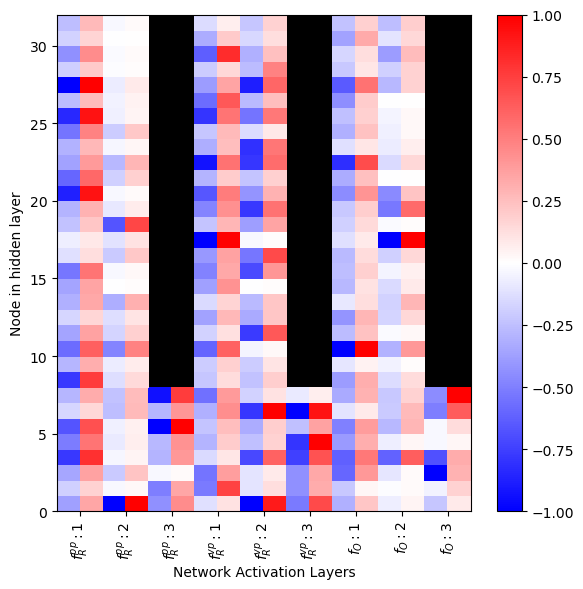

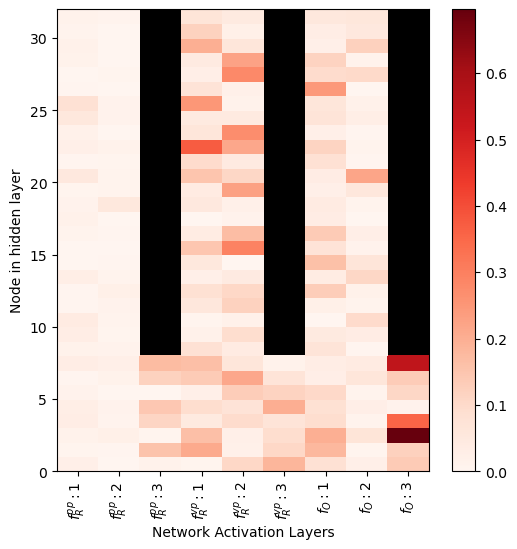

gnn_pfeaturesdropped_0001_model_metadata.json
Sparsity measure (RNA < 0.2) for QCD jets:  0.4203703703703704
Sparsity measure (RNA < 0.2) for Hbb jets:  0.42407407407407405


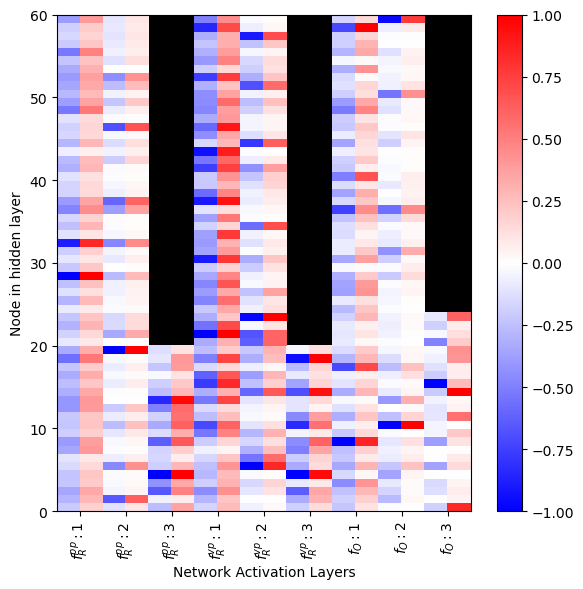

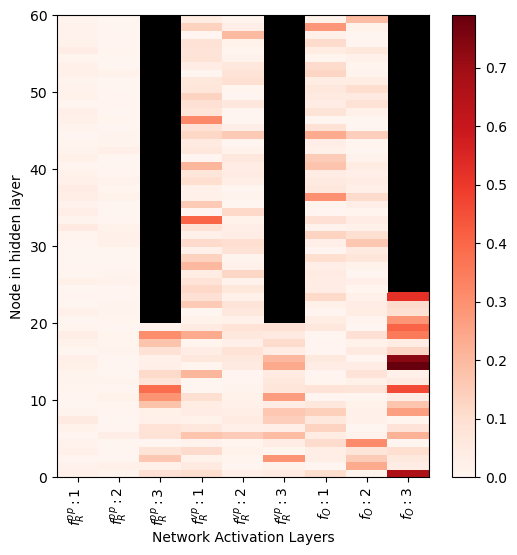

gnn_pfeaturesdropped_0001_preload_model_metadata.json
Sparsity measure (RNA < 0.2) for QCD jets:  0.45
Sparsity measure (RNA < 0.2) for Hbb jets:  0.44074074074074077


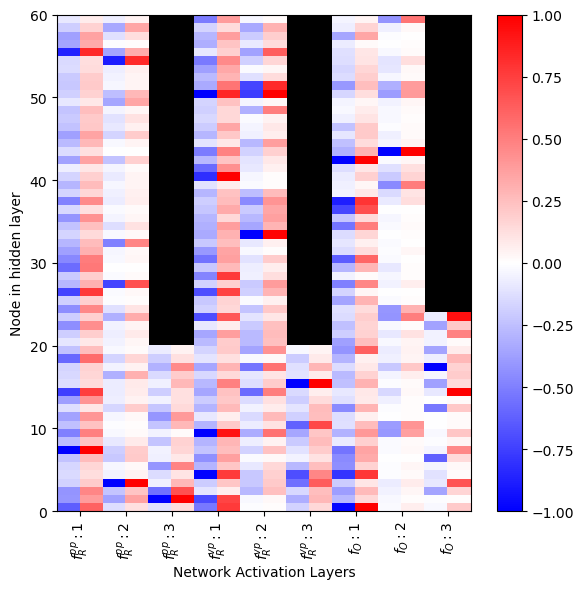

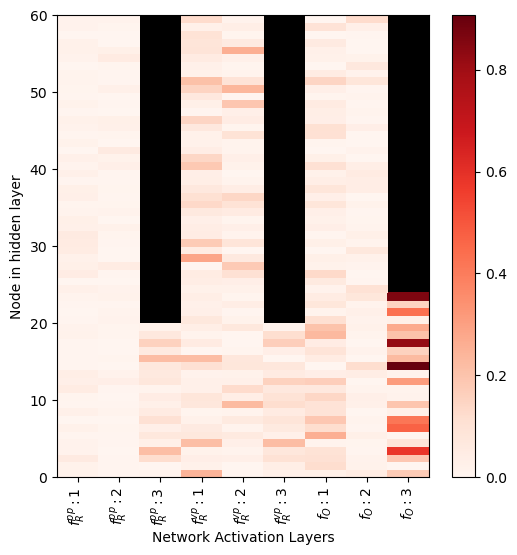

gnn_pfeaturesdropped_0005_model_metadata.json
Sparsity measure (RNA < 0.2) for QCD jets:  0.3962962962962963
Sparsity measure (RNA < 0.2) for Hbb jets:  0.4351851851851852


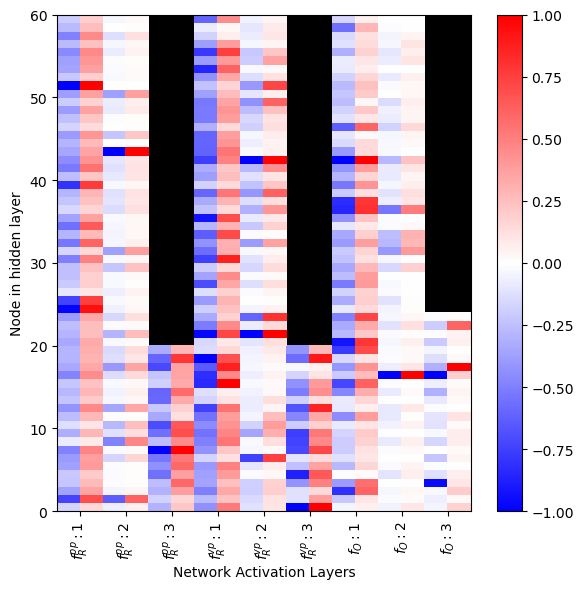

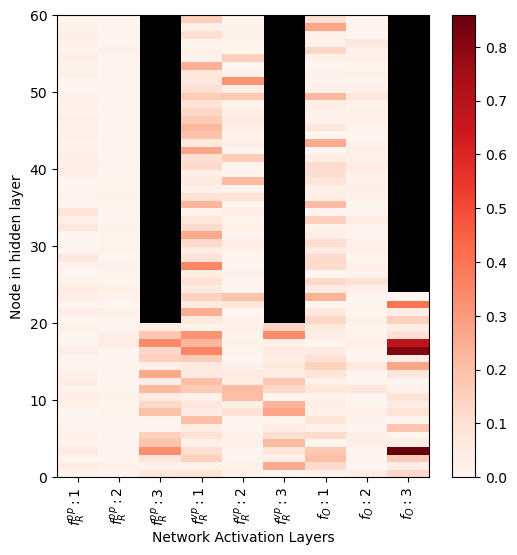

gnn_pfeaturesdropped_0005_preload_model_metadata.json
Sparsity measure (RNA < 0.2) for QCD jets:  0.43703703703703706
Sparsity measure (RNA < 0.2) for Hbb jets:  0.4222222222222222


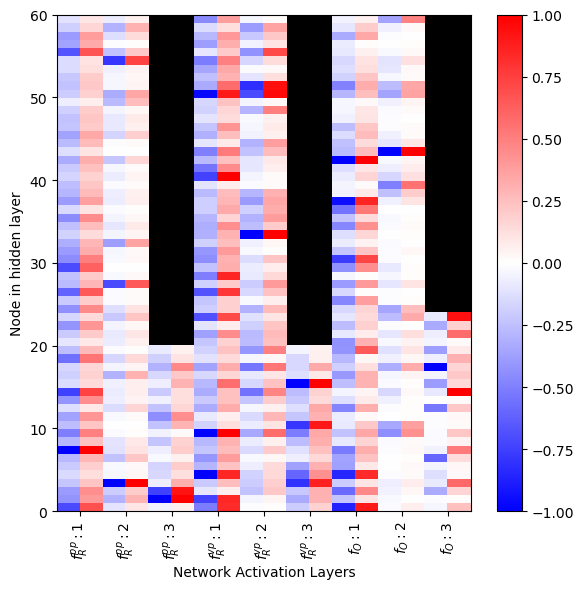

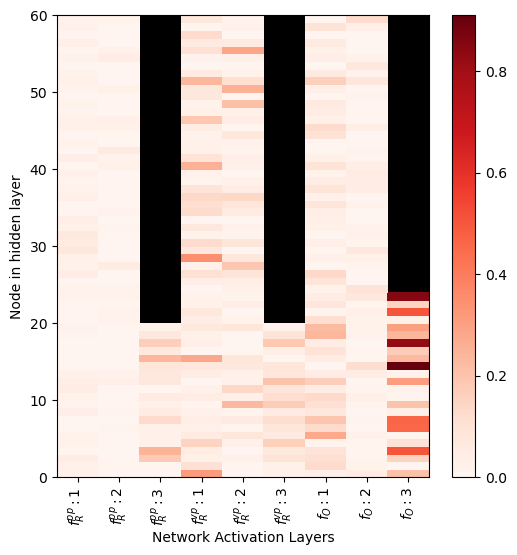

gnn_pfeaturesdropped_001_model_metadata.json
Sparsity measure (RNA < 0.2) for QCD jets:  0.46111111111111114
Sparsity measure (RNA < 0.2) for Hbb jets:  0.48148148148148145


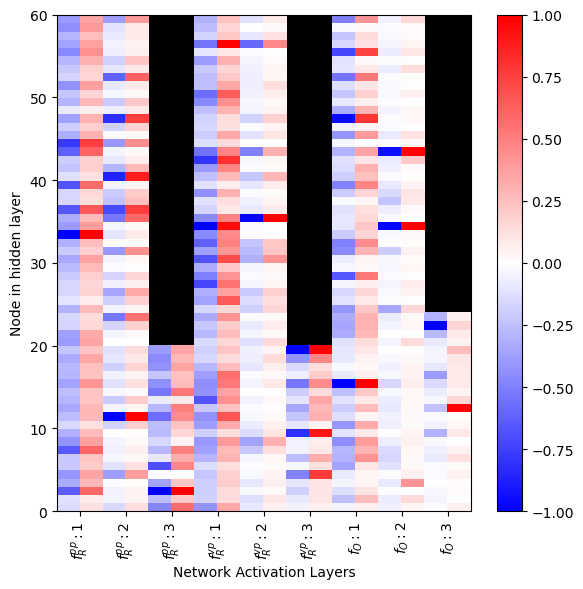

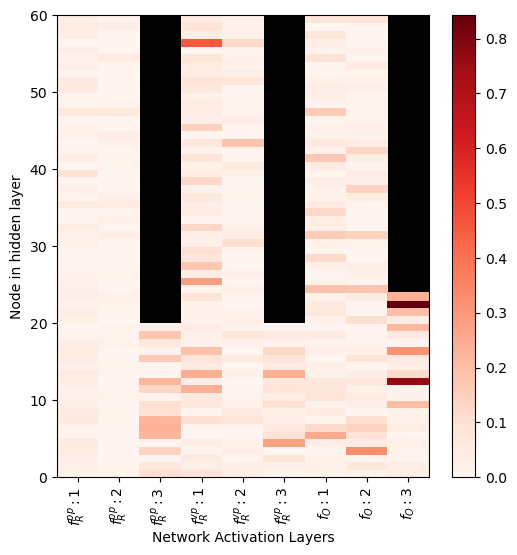

gnn_pfeaturesdropped_001_preload_model_metadata.json
Sparsity measure (RNA < 0.2) for QCD jets:  0.4462962962962963
Sparsity measure (RNA < 0.2) for Hbb jets:  0.4351851851851852


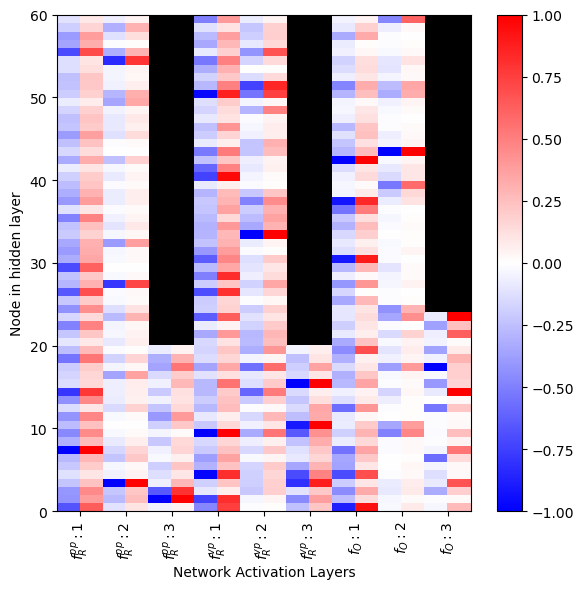

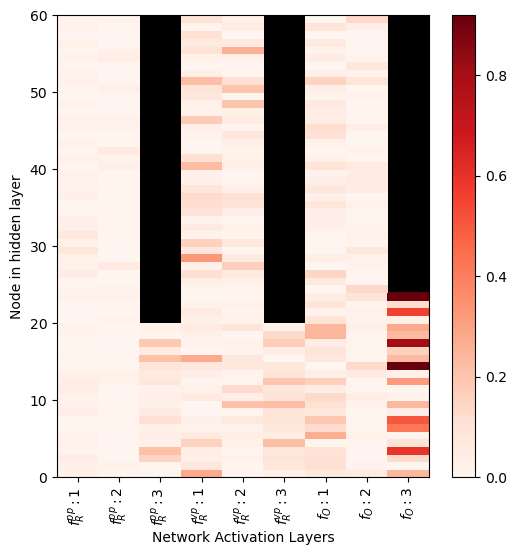

gnn_pfeaturesdropped_005_model_metadata.json
Sparsity measure (RNA < 0.2) for QCD jets:  0.49074074074074076
Sparsity measure (RNA < 0.2) for Hbb jets:  0.46111111111111114


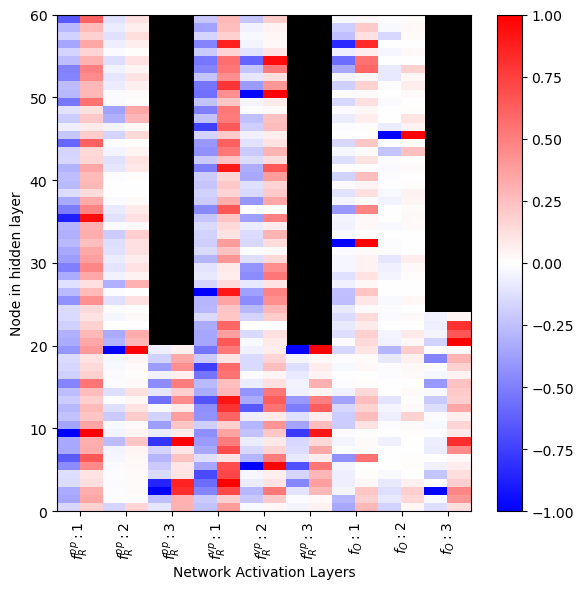

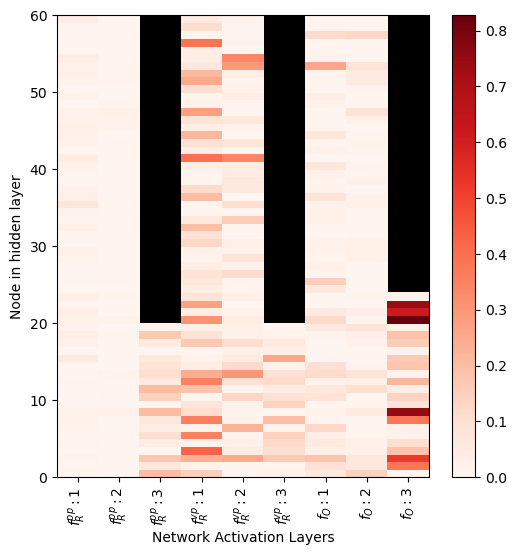

gnn_pfeaturesdropped_005_preload_model_metadata.json
Sparsity measure (RNA < 0.2) for QCD jets:  0.43148148148148147
Sparsity measure (RNA < 0.2) for Hbb jets:  0.42777777777777776


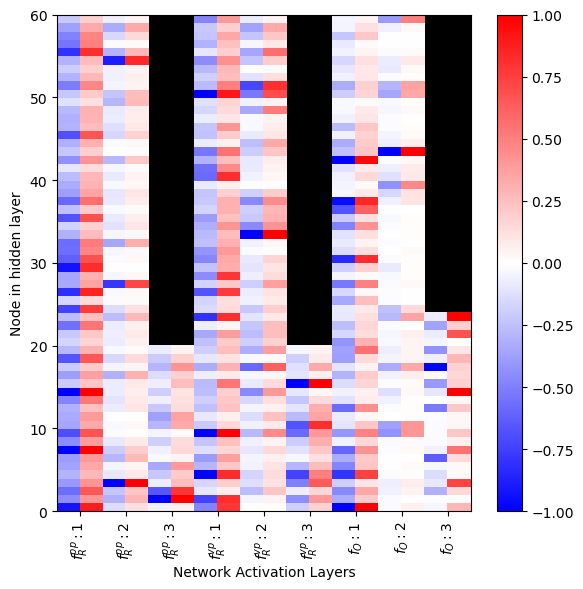

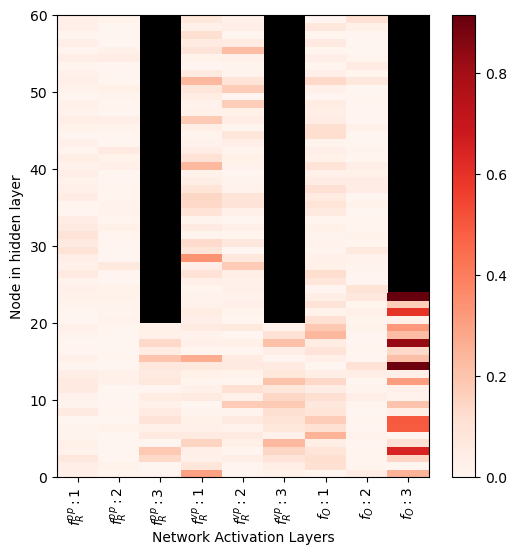

gnn_pfeaturesdropped_100_model_metadata.json
Sparsity measure (RNA < 0.2) for QCD jets:  0.4148148148148148
Sparsity measure (RNA < 0.2) for Hbb jets:  0.42962962962962964


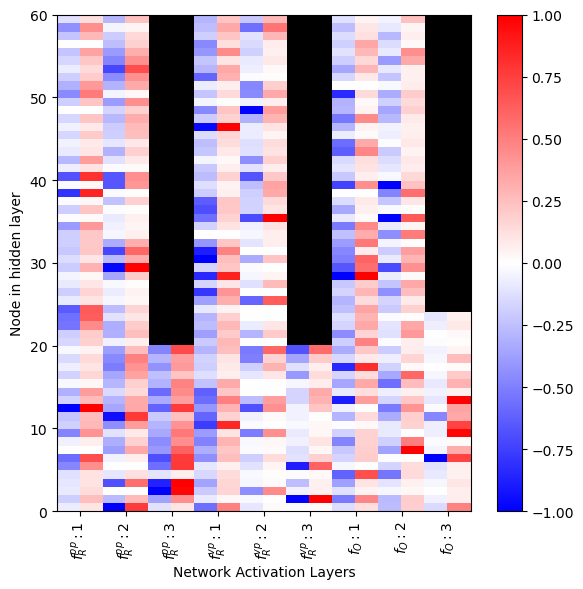

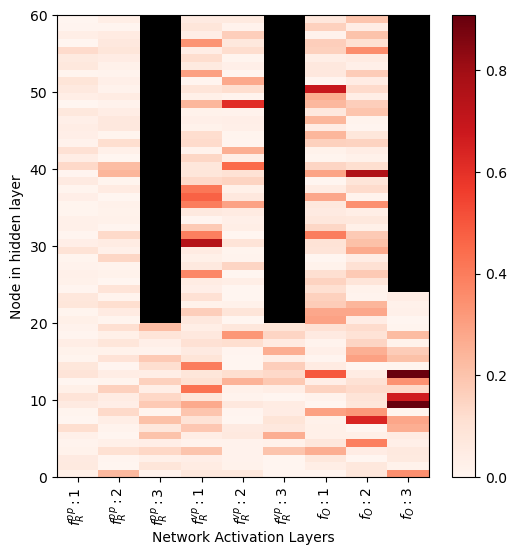

gnn_pfeaturesdropped_100_preload_model_metadata.json
Sparsity measure (RNA < 0.2) for QCD jets:  0.4222222222222222
Sparsity measure (RNA < 0.2) for Hbb jets:  0.42407407407407405


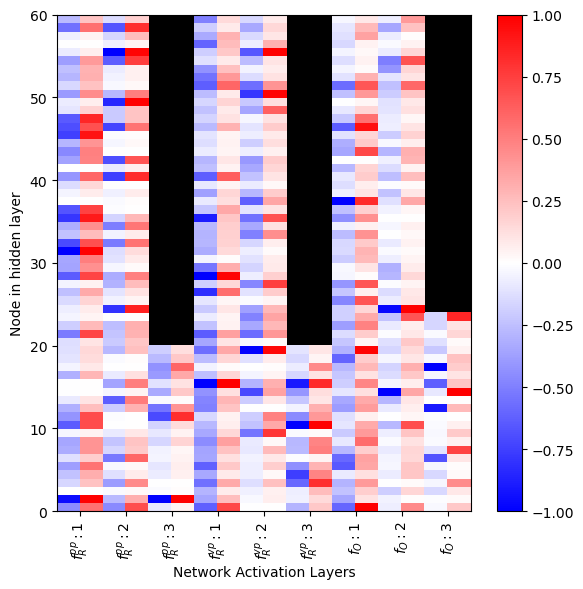

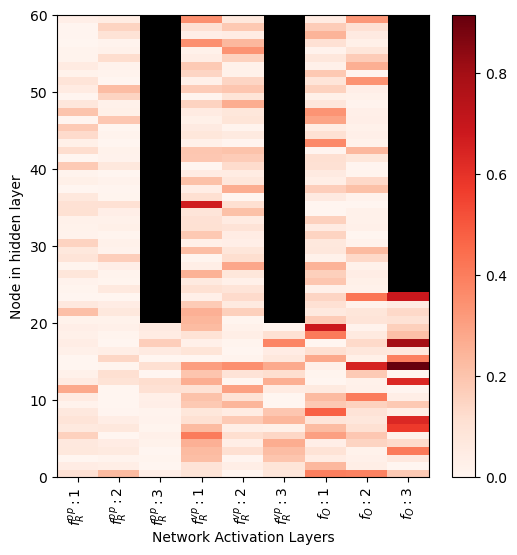

gnn_psvfeaturesdropped_0001_preload_model_metadata.json
Sparsity measure (RNA < 0.2) for QCD jets:  0.45185185185185184
Sparsity measure (RNA < 0.2) for Hbb jets:  0.4444444444444444


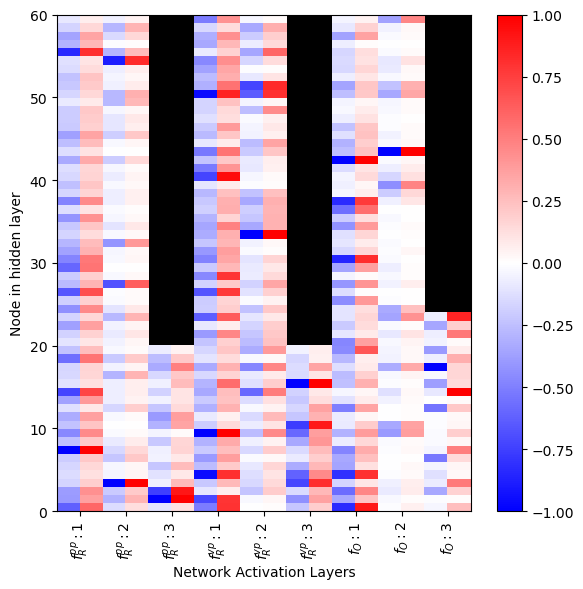

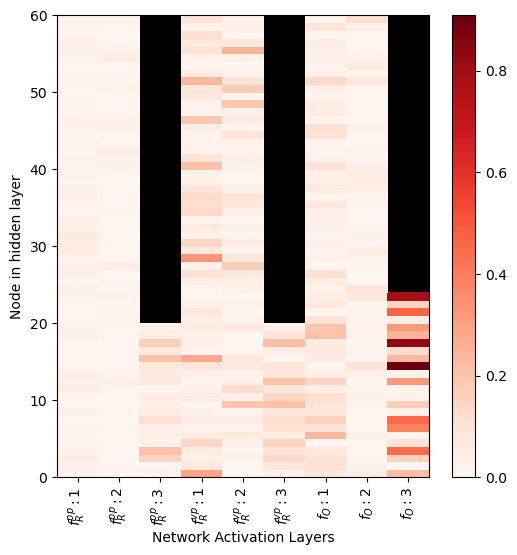

gnn_psvfeaturesdropped_0005_preload_model_metadata.json
Sparsity measure (RNA < 0.2) for QCD jets:  0.4537037037037037
Sparsity measure (RNA < 0.2) for Hbb jets:  0.43703703703703706


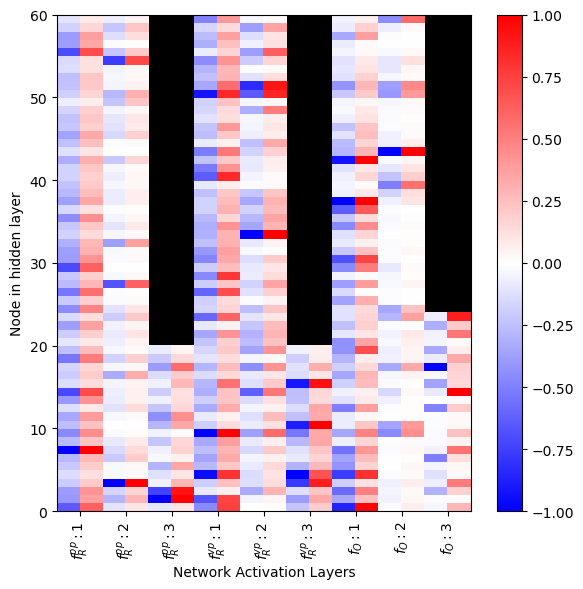

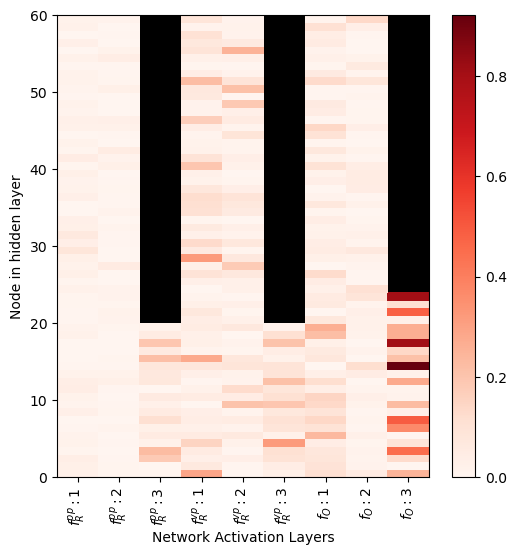

gnn_psvfeaturesdropped_001_noTrackQ_hidden16_De8_Do8_model_metadata.json
Sparsity measure (RNA < 0.2) for QCD jets:  0.3194444444444444
Sparsity measure (RNA < 0.2) for Hbb jets:  0.3541666666666667


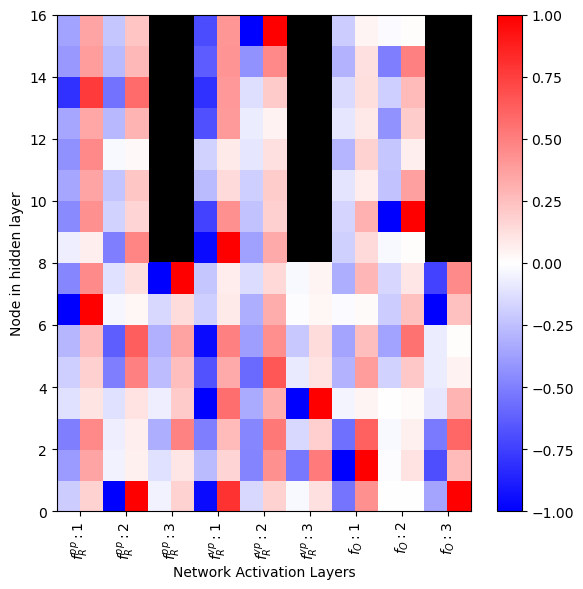

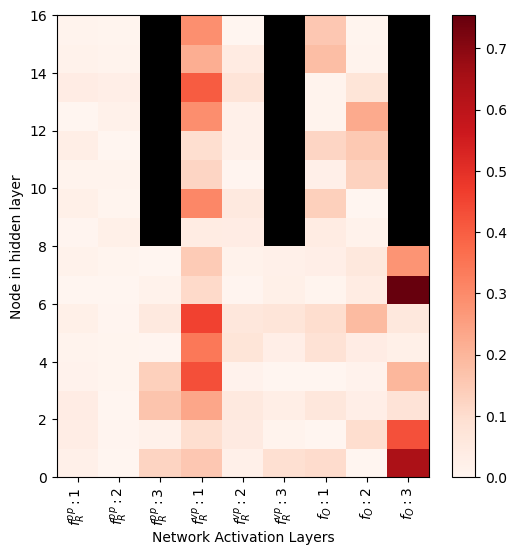

gnn_psvfeaturesdropped_001_noTrackQ_hidden32_De16_Do16_model_metadata.json
Sparsity measure (RNA < 0.2) for QCD jets:  0.4340277777777778
Sparsity measure (RNA < 0.2) for Hbb jets:  0.4409722222222222


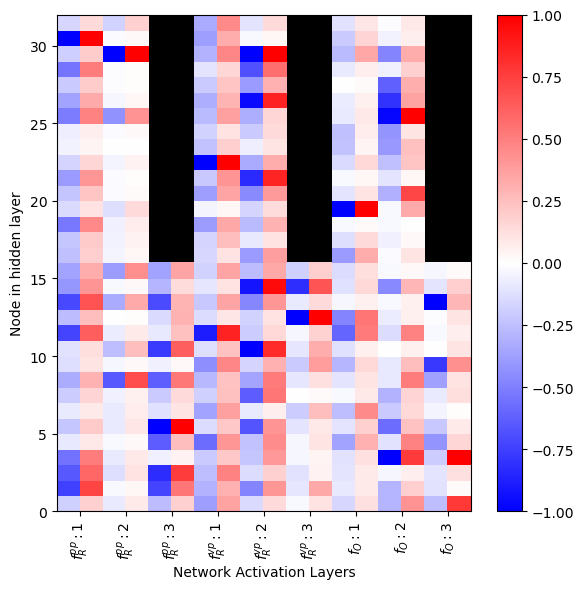

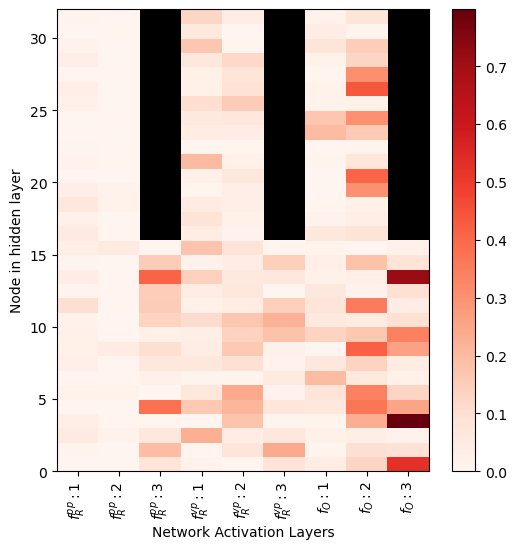

gnn_psvfeaturesdropped_001_noTrackQ_hidden32_De8_Do8_model_metadata.json
Sparsity measure (RNA < 0.2) for QCD jets:  0.3541666666666667
Sparsity measure (RNA < 0.2) for Hbb jets:  0.3715277777777778


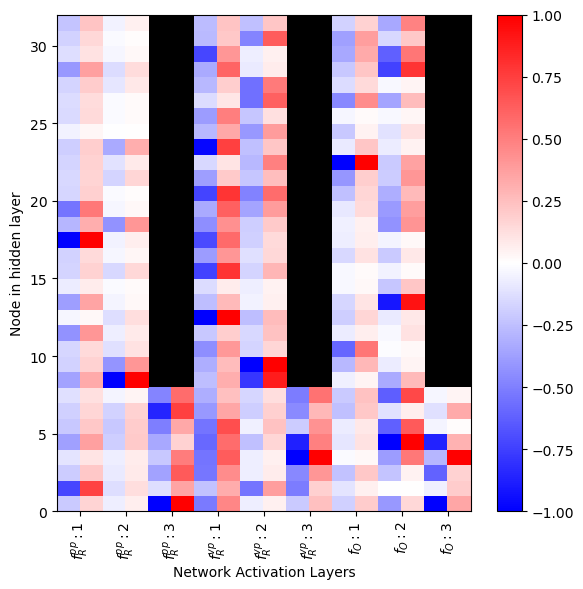

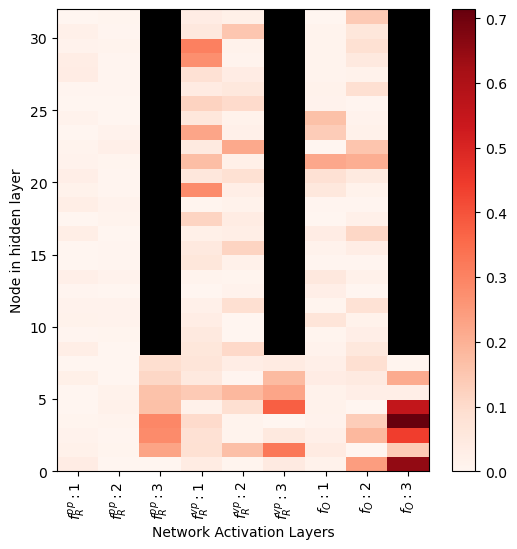

gnn_psvfeaturesdropped_001_noTrackQ_model_metadata.json
Sparsity measure (RNA < 0.2) for QCD jets:  0.45555555555555555
Sparsity measure (RNA < 0.2) for Hbb jets:  0.4703703703703704


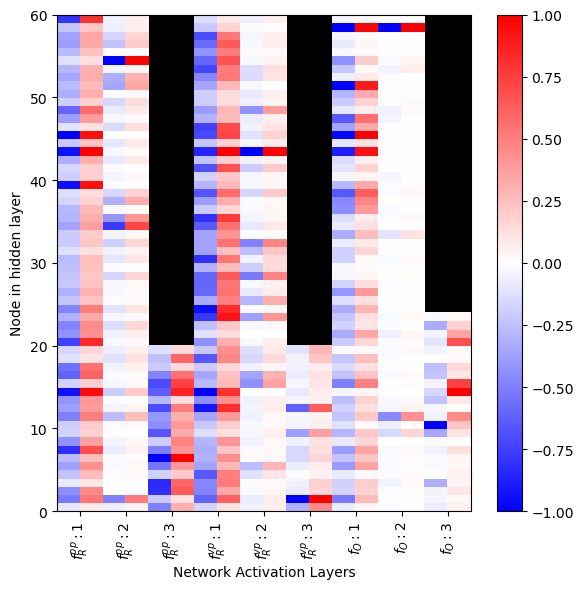

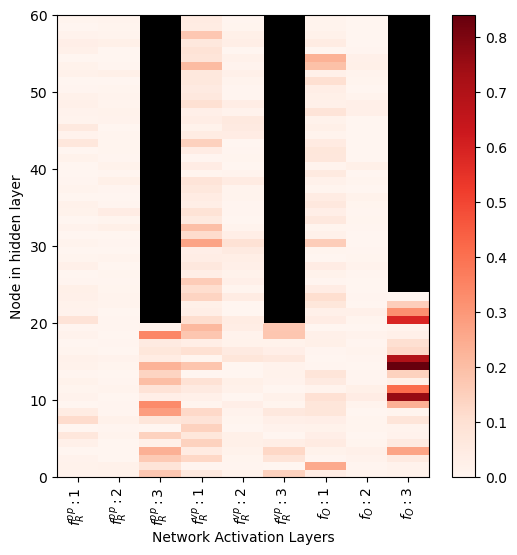

gnn_psvfeaturesdropped_001_preload_model_metadata.json
Sparsity measure (RNA < 0.2) for QCD jets:  0.45925925925925926
Sparsity measure (RNA < 0.2) for Hbb jets:  0.4537037037037037


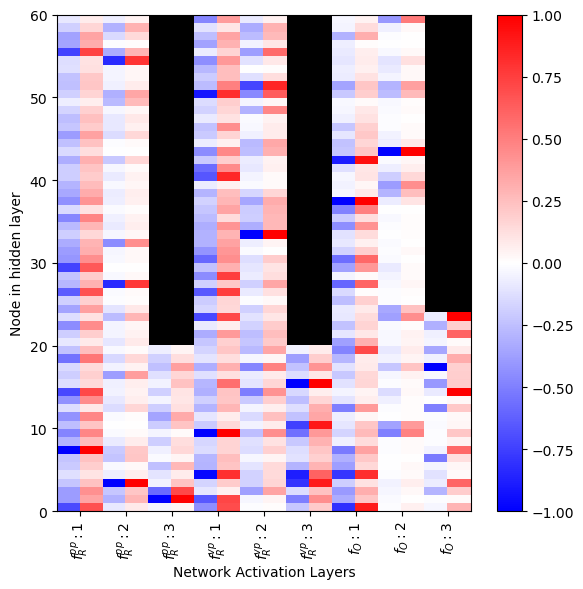

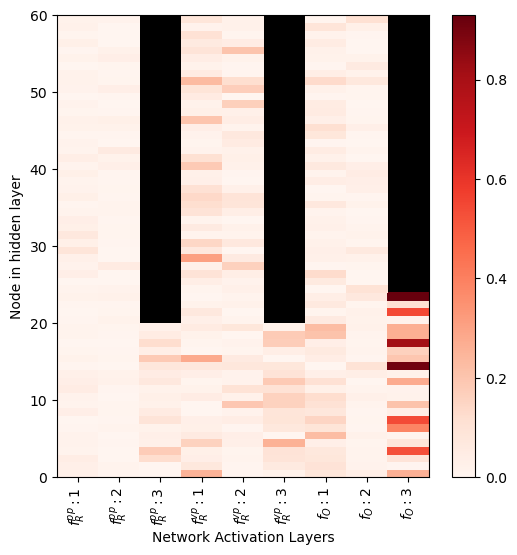

gnn_psvfeaturesdropped_005_noTrackQ_model_metadata.json
Sparsity measure (RNA < 0.2) for QCD jets:  0.48333333333333334
Sparsity measure (RNA < 0.2) for Hbb jets:  0.47962962962962963


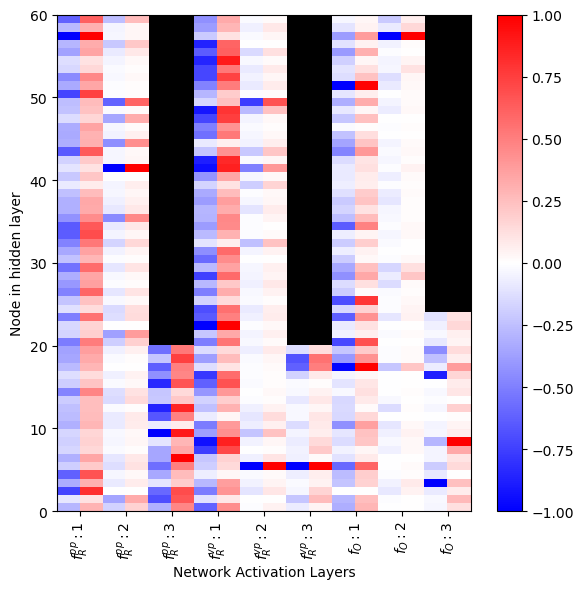

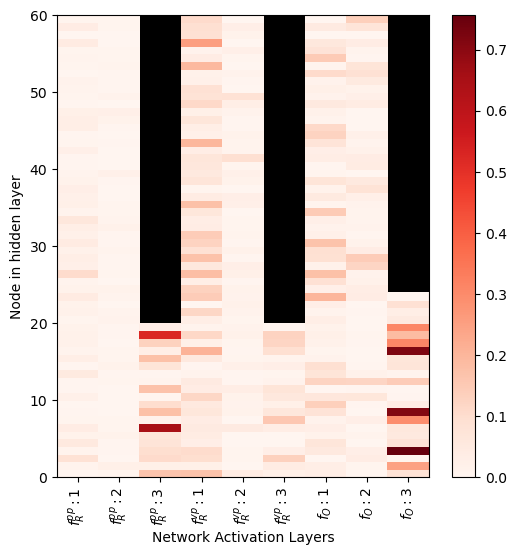

gnn_psvfeaturesdropped_005_preload_model_metadata.json
Sparsity measure (RNA < 0.2) for QCD jets:  0.43703703703703706
Sparsity measure (RNA < 0.2) for Hbb jets:  0.43703703703703706


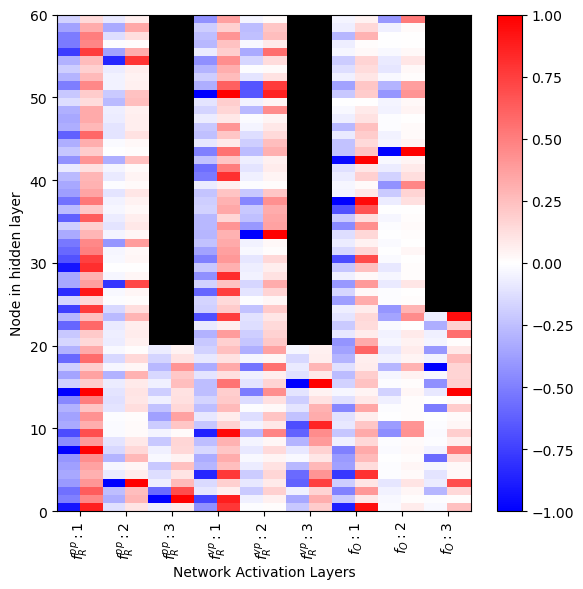

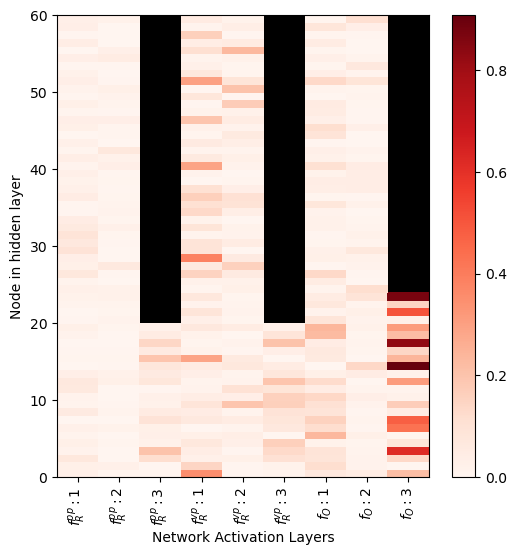

gnn_psvfeaturesdropped_100_preload_model_metadata.json
Sparsity measure (RNA < 0.2) for QCD jets:  0.43333333333333335
Sparsity measure (RNA < 0.2) for Hbb jets:  0.44074074074074077


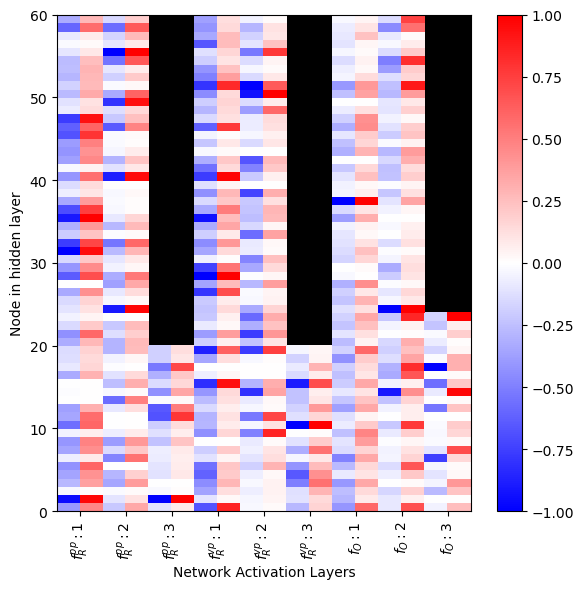

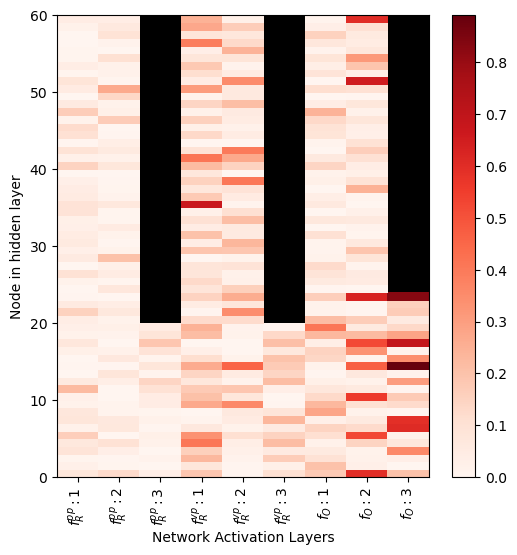

In [9]:
All_Models = sorted(list(os.listdir("../models/model_dicts/")))

for model_file in All_Models:
    if "baseline" in model_file:
        continue
    print(model_file)
    model_md = json.load(open("../models/model_dicts/" + model_file))
    model_name = '../models/trained_models/' + model_file.replace('model_metadata.json', 'best.pth')
    model_tag = model_md['label']
    drop_pfeatures = model_md['drop_pfeatures']
    if drop_pfeatures != "":
        drop_pfeatures = list(map(int, drop_pfeatures.split(','))) 
    else:
        drop_pfeatures = []
        
    drop_svfeatures = model_md['drop_svfeatures']
    if drop_svfeatures != "":
        drop_svfeatures = list(map(int, drop_svfeatures.split(','))) 
    else:
        drop_svfeatures = []
    hidden = model_md['hidden']
    De = model_md['De']
    Do = model_md['Do']
    this_gnn = models.GraphNet(60, 2, len(params) - len(drop_pfeatures), 
                               hidden, 5, len(params_sv) - len(drop_svfeatures),
                               vv_branch=0,
                               De=De,
                               Do=Do)
    this_gnn.load_state_dict(torch.load(model_name))
    _, _, FiringMatrix_0, layer_tags = eval(this_gnn, 
                                            drop_pfeatures = drop_pfeatures,
                                            drop_svfeatures = drop_svfeatures,
                                            target_label = 0, weighted_firing = True)
    _, _, FiringMatrix_1, layer_tags = eval(this_gnn, 
                                            drop_pfeatures = drop_pfeatures,
                                            drop_svfeatures = drop_svfeatures,
                                            target_label = 1, weighted_firing = True)
    tag = model_tag
    ActivationMapPlotter(FiringMatrix_0, FiringMatrix_1, layer_tags, tag)